In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Watermass transformation and overturning in ECCO
21/05/21
- Look at the balance of terms in wmt within distinct watermasses

In [41]:
import xarray as xr
import so_decadal_variability as so
import matplotlib.pyplot as plt
import numpy as np
import utils.operations as op

In [42]:
rootdir = '../../data/processed/ECCO/'
filename_all = 'binned_vol_budget_month_dGamman_0.02_BF_G.nc'
filename_bowl = 'binned_vol_budget_month_dGamman_0.02_bowl_p2_BF_G.nc'
ds_all = xr.open_dataset(rootdir+filename_all).isel(gamma_n=slice(1,-1))
ds_bowl = xr.open_dataset(rootdir+filename_bowl).isel(gamma_n=slice(1,-1))

In [43]:
# Only retain non-zero values
# (This relies on the fact that nowhere else is exactly zero)
ds_all = ds_all.where(ds_all['bin_ADV']!=0,drop=True)
ds_bowl = ds_bowl.where(ds_bowl['bin_ADV']!=0,drop=True)

#### Getting watermass boundaries
- WM boundaries are selected based on overturning at the northern boundary  
- Look for maxima and zero crossing to define watermasses  
- Define uncertainties arouund the wm bounds

In [46]:
X = ds_all['bin_ADV'].mean('time')
Xsmooth = X.rolling({'gamma_n':5},center=True).mean()
# Find the crossing points of the time-mean advection
c = op.crossing(Xsmooth,'gamma_n')
ex = op.extrema(Xsmooth,'gamma_n',order=10)
# List and sort them
bounds = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))
bounds
# Uncertainty
dr = 0.1

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


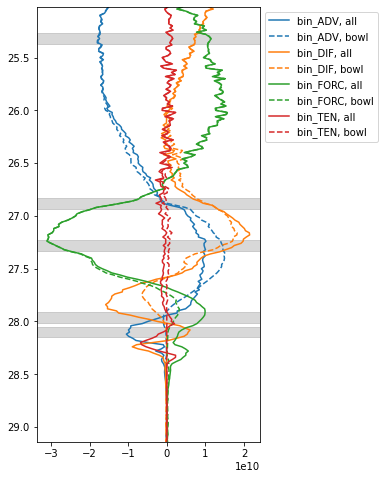

In [48]:
# Replot, with watermasses
fig,ax = plt.subplots(figsize=(4,8))
for term in terms:
    ax.plot(ds_all[term].mean('time'),ds_all['gamma_n'],
            label=term+', all',color=colors[term])
    ax.plot(ds_bowl[term].mean('time'),ds_bowl['gamma_n'],
            label=term+', bowl',color=colors[term],linestyle='--')
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
xlim = ax.get_xlim()
for b in bounds:
    p = plt.Rectangle((xlim[0],b-dr/2),
                      np.diff(xlim),dr,color='gray',alpha=0.3)
    ax.add_patch(p)
ax.autoscale(enable=True, axis='x', tight=True)

### Calculate integrated formation within bounds

In [99]:
# Calculate formation
formation_all = -1*ds_all.diff('gamma_n')
formation_bowl = -1*ds_bowl.diff('gamma_n')
# Find boundaries and center point of watermasses
bins = np.concatenate(([ds_all['gamma_n'].min('gamma_n')],bounds,[ds_all['gamma_n'].max('gamma_n')]))
bins_c = 0.5*(bins[1:]+bins[:-1])
# Set up empty datasets
mns = xr.Dataset()
mxs = xr.Dataset()
avs = xr.Dataset()
# Loop through terms
for term in terms:
    # Set up dummy arrays
    mn = np.zeros(shape=(len(bins_c),
                         len(formation_bowl['time'])))
    mx = np.zeros(shape=(len(bins_c),
                         len(formation_bowl['time'])))
    av = np.zeros(shape=(len(bins_c),
                         len(formation_bowl['time'])))
    # Loop through boundaries
    for b,lb in enumerate(bins[:-1]):
        ub = bins[b+1]
        # Define arrays that capture range of values around bounds
        lowers = np.linspace(lb-dr/2,lb+dr/2,10)
        uppers = np.linspace(ub-dr/2,ub+dr/2,10)
        # Set up tmp array to accept all integrated values
        tmp = np.zeros(shape=(len(lowers)*len(uppers),
                              len(formation_bowl['time'])))
        # Loop through boundary ranges
        count=0
        for l in lowers:
            for u in uppers:
                # Integrate formation between bounds
                tmp[count,:]=formation_all[term].sel(
                           {'gamma_n':slice(l,u)}).sum('gamma_n')
                count+=1
        # Determine min, max, and average formation for this watermass
        # This provides the range of uncertainty for watermass definition
        mn[b,:] = np.min(tmp,axis=0)
        mx[b,:] = np.max(tmp,axis=0)
        av[b,:] = np.mean(tmp,axis=0)
    # Place in dataset
    mns[term]=(['gamma_n_bins','time'],mn)
    mxs[term]=(['gamma_n_bins','time'],mx)
    avs[term]=(['gamma_n_bins','time'],av)
# Assign coordinates of dataset
mns = mns.assign_coords({'time':ds_all['time'],'gamma_n_bins':bins_c})
mxs = mxs.assign_coords({'time':ds_all['time'],'gamma_n_bins':bins_c})
avs = avs.assign_coords({'time':ds_all['time'],'gamma_n_bins':bins_c})

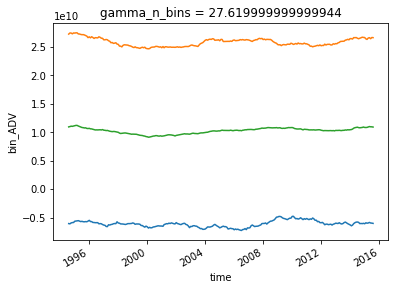

In [100]:
mns['bin_ADV'].isel(gamma_n_bins=3).rolling(time=60,center=True).mean().plot()
mxs['bin_ADV'].isel(gamma_n_bins=3).rolling(time=60,center=True).mean().plot()
avs['bin_ADV'].isel(gamma_n_bins=3).rolling(time=60,center=True).mean().plot()


In [31]:
bins = np.concatenate(([ds_all['gamma_n'].min('gamma_n')],bounds,[ds_all['gamma_n'].max('gamma_n')]))
bins_c = 0.5*(bins[1:]+bins[:-1])
bins_w = np.diff(bins)
wmf_all = formation_all.groupby_bins('gamma_n',bins,labels=bins_c).sum()
wmf_bowl = formation_bowl.groupby_bins('gamma_n',bins,labels=bins_c).sum()
wmf_int = wmf_all - wmf_bowl

<BarContainer object of 6 artists>

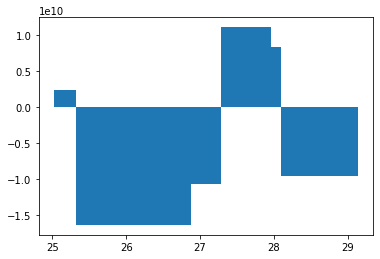

In [32]:
# Plot the overturning
plt.bar(wmf_all['gamma_n_bins'],wmf_all['bin_ADV'].mean('time'),width=bins_w)

### Plot time series of balance for each watermass

In [33]:
# Add together surface forcing and diffusion within bowl
wmf_all['bin_FORCDIF'] = wmf_all['bin_FORC']+wmf_all['bin_DIF']
wmf_bowl['bin_FORCDIF'] = wmf_bowl['bin_FORC']+wmf_bowl['bin_DIF']
wmf_int['bin_FORCDIF'] = wmf_int['bin_FORC']+wmf_int['bin_DIF']
colors['bin_FORCDIF'] = 'tab:purple'
termsnew = terms.copy()
termsnew.append('bin_FORCDIF')

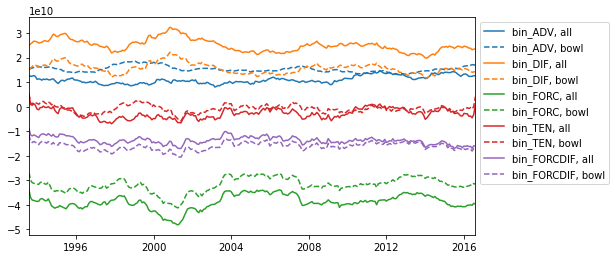

In [36]:
# Plot total and bowl
g = bins_c[3]
fig,ax = plt.subplots(figsize=(8,4))
for term in termsnew:
    ax.plot(wmf_all['time'],wmf_all[term].sel({'gamma_n_bins':g},method='nearest').rolling({'time':36},center=True).mean(),
            label=term+', all',color=colors[term])
    ax.plot(wmf_bowl['time'],wmf_bowl[term].sel({'gamma_n_bins':g},method='nearest').rolling({'time':36},center=True).mean(),
            label=term+', bowl',color=colors[term],linestyle='--')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

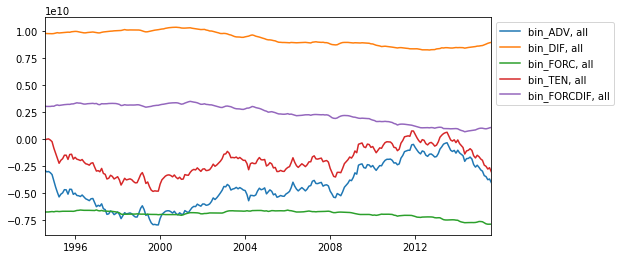

In [37]:
# Plot interior
g = bins_c[3]
fig,ax = plt.subplots(figsize=(8,4))
for term in termsnew:
    ax.plot(wmf_int['time'],wmf_int[term].sel({'gamma_n_bins':g},method='nearest').rolling({'time':60},center=True).mean(),
            label=term+', all',color=colors[term])
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

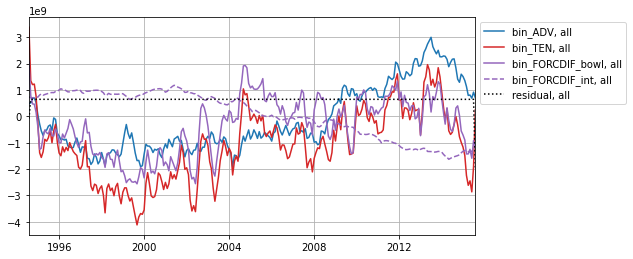

In [38]:
# Plot full advection, full tendency, bowl wmt, and subsurface wmt
termsnew = ['bin_ADV','bin_TEN','bin_FORCDIF_bowl','bin_FORCDIF_int'];
ds = xr.Dataset()
ds['bin_ADV'] = wmf_all['bin_ADV']
ds['bin_TEN'] = wmf_all['bin_TEN']
ds['bin_FORCDIF_bowl'] = wmf_bowl['bin_FORCDIF']
ds['bin_FORCDIF_int'] = wmf_all['bin_FORCDIF'] - wmf_bowl['bin_FORCDIF']
ds['residual'] = -1*ds['bin_TEN'] + ds['bin_ADV'] + ds['bin_FORCDIF_bowl'] + ds['bin_FORCDIF_int']
colorsnew = {'bin_ADV':'tab:blue','bin_TEN':'tab:red','bin_FORCDIF_bowl':'tab:purple','bin_FORCDIF_int':'tab:purple','residual':'black'}
lines = {'bin_ADV':'-','bin_TEN':'-','bin_FORCDIF_bowl':'-','bin_FORCDIF_int':'--','residual':':'}

g = bins_c[3]
fig,ax = plt.subplots(figsize=(8,4))
residual = xr.zeros_like(ds['bin_ADV'].sel({'gamma_n_bins':g},method='nearest'))
for term in ds.data_vars:
    val = ds[term].sel({'gamma_n_bins':g},method='nearest')
    anom = val - val.mean('time')
    smoothed = anom.rolling({'time':60},center=True).mean()
    ax.plot(ds['time'],smoothed,
            label=term+', all',color=colorsnew[term],linestyle=lines[term])
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid()

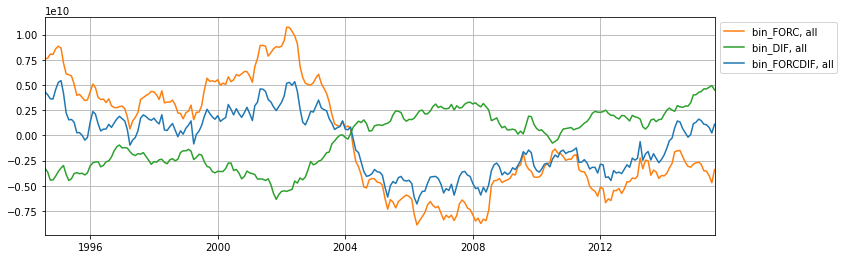

In [39]:
# Plot separation of variability between 
# diffusive and surface forcing terms
termsnew = ['bin_FORC','bin_DIF','bin_FORCDIF'];
colornew = {'bin_FORCDIF':'tab:blue','bin_FORC':'tab:orange','bin_DIF':'tab:green'}
g = bins_c[2]
fig,ax = plt.subplots(figsize=(12,4))
for term in termsnew:
    val = wmf_bowl[term].sel({'gamma_n_bins':g},method='nearest')
    anom = val - val.mean('time')
    smoothed = anom.rolling({'time':60},center=True).mean()
    ax.plot(ds['time'],smoothed,
            label=term+', all',color=colornew[term])
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid()